In [1]:
import matplotlib.pyplot as plt
import numpy as np

import fnmatch
import os
import pickle

#import yasa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)
import mne
import numpy as np

#e = mne.io.read_raw('/Volumes/Research/eng_research_scottlab/RATACAD_DATA/rawEEG/2022-06-08_raw.fif.gz',on_split_missing ='ignore')
e = mne.io.read_raw('2022-06-08_raw.fif.gz',on_split_missing ='ignore')
ed = e.copy().resample(sfreq=200)

Opening raw data file 2022-06-08_raw.fif.gz...
Isotrak not found
    Range : 0 ... 86396024 =      0.000 ... 86396.024 secs
Ready.


In [2]:
import datajoint as dj
from dj_ratacad import flashcount
data=(flashcount.FlashCountTrial() & 'name = "Squirtle"' & 'outcome != "Omission"').fetch(format="frame")
data = data.reset_index(level=['trial_datetime', 'stage'])

#from dj_ratacad import flashes
#data=(flashes.FlashesTrial() & 'name = "1062"' & 'outcome != "Omission"').fetch(format="frame")
#data = data.reset_index(level=['trial_datetime', 'stage'])

import pandas as pd
data['Date'] = pd.to_datetime(data['trial_datetime']).dt.date
data['Hour'] = pd.to_datetime(data['trial_datetime']).dt.hour

DataJoint verified plugin `datajoint_connection_hub` detected.
Connecting qdo@buaws-aws-cf-rds-mysql-prod.cenrervr4svx.us-east-2.rds.amazonaws.com:3306


In [77]:
import pandas as pd
def get_sec(time_str):
    """Get seconds from time."""
    h, m, s = str(time_str).split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)
#data['Time'] = pd.to_datetime(data['trial_datetime']).dt.time
#data['S'] = data['Time'].apply(get_sec)
#dt = data.loc[data['Date'] == pd.Timestamp('2022-06-08')]
#dt.loc[:,"S"]
#data
data['Date'] = pd.to_datetime(data['trial_datetime'],utc=True).dt.date
data['Hour'] = pd.to_datetime(data['trial_datetime'],utc=True).dt.hour

data['Time'] = pd.to_datetime(data['trial_datetime'],utc=True).dt.time
data['Datetime'] = pd.to_datetime(data['trial_datetime'],utc=True)
data['S'] = data['Time'].apply(get_sec)

#dt = data.loc[(data['trial_datetime'] >= pd.Timestamp(2022,6,7,22,0))]
#dt
#dt = data.loc[(data['trial_datetime'] >= pd.Timestamp(2022,6,8,0,0)) & (data['trial_datetime'] <= pd.Timestamp(2022,6,9,0,0))]
#dt

In [262]:
events = mne.find_events(ed, stim_channel=['STIM3'],shortest_event=1,min_duration=0.01,initial_event=True,consecutive=True,verbose=0)
ChoiceEvent=events[events[:,2]==4] #choice
wheretostop = (len(ChoiceEvent[:,2]))
starttime = pd.Timestamp(2022,6,7,21,18,41)
dt = data.loc[(data['trial_datetime'] > starttime)]
dt = dt.iloc[:wheretostop]
starttime = dt['trial_datetime'].iloc[-1]
print(starttime)
ChoiceEvent=events[events[:,2]==4]
choiceLabel = np.array(dt.loc[:,"choice"])
rewardLabel = np.array(dt.loc[:,"outcome"])
dt['lflash'] = dt['flashes_left'].str.count('1')
dt['rflash'] = dt['flashes_right'].str.count('1')
dt['dflash'] = abs(dt['rflash'] - dt['lflash'])
for i in range(len(choiceLabel)):
    if (choiceLabel[i] == "left") and (rewardLabel[i] == "error"):
        choiceLabel[i] = 0 #left wrong
    elif (choiceLabel[i] == "left") and (rewardLabel[i] == "correct"):
        choiceLabel[i] = 1 #Left correct
    elif (choiceLabel[i] == "right") and (rewardLabel[i] == "error"):
        choiceLabel[i] = 0 #right wrong
    elif (choiceLabel[i] == "right") and (rewardLabel[i] == "correct"):
        choiceLabel[i] = 1 #right correct
    elif choiceLabel[i] == "earlyleft":
        choiceLabel[i] = -1 #early left
    else:
        choiceLabel[i] = -1 #early right
flashDiff = np.array(dt.loc[:,"dflash"])
for i in range(len(choiceLabel)):
    if (choiceLabel[i] == 1):#
        if (flashDiff[i] > 5):
            choiceLabel[i] = 2
        else:
            choiceLabel[i] = 1
    
ChoiceEvent[:,2] = choiceLabel
event_dict2 = {'w':2,
             'r':1}
choice_epochs = mne.Epochs(ed, ChoiceEvent,event_id=event_dict2, tmin=-3, tmax=0.5, preload=True,event_repeated='drop')

epochs_train = choice_epochs.copy()
labels = choice_epochs.events[:, -1]
epochs_data_train = epochs_train.get_data()


2022-06-08 22:49:38
Not setting metadata
393 matching events found
Setting baseline interval to [-3.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 393 events and 701 original time points ...
0 bad epochs dropped


In [263]:
import matplotlib.pyplot as plt

import mne
from sklearn.preprocessing import StandardScaler
import numpy as np
def nextexp(value, base=2):
    """
    Given a value and an optional base, this function returns the exponent for
    the smallest powers of the specified base that satisfy:
    base**exponent >= |value|.

    Parameters
    ----------
    value : numeric
        The value that will be compared to the succesive powers of the base
        until the previous condition is met.
    base : numeric, optional
        The base of the power. Default value is 2.

    Returns
    -------
    int
        Exponent that meets the previous condition.

    """
    exponent = 0
    while base ** exponent < np.abs(value):
        exponent += 1
    return exponent

def mne_stockell_power(data, samplingrate, window_lenght = [-3,0.5], freq_range = [0,100]):
    """
        Computes a high temporal and frequency resolution spectrogram and intertrial coherence
        using the mne.time_frequency.tfr_array_stockwell function (https://mne.tools/stable/generated/mne.time_frequency.tfr_array_stockwell.html).
        It is set up to have a time resolution of 10ms and a frequency resolution depends on the window length.

        Parameters
        ----------
        data : ndarray
            The shape has to be (n_epochs, n_channels, n_times).
            For instance the shape for 2 events, 3 channels and 3000 points
            (3 seconds sampled at 1000) would be (1, 3, 3000)
        samplingrate : numeric
            Sampling frequency in Hz
        window_lenght: list, two numbers
            The seconds before the start of the trial, first number, and after
            the start of the trial, second number, that you want to plot.
        freq_rage: list, two numbers
        The frequency range that you want to calculate.


        Returns
        -------
        st_power: ndarray
            The multitaper power of the Stockwell transformed data.
            The last two dimensions are frequency and time. Shape (n_channels, n_freqs, n_time).
            It should have the same lenght of freqs, dimension 2, and time, dimension 3.
        itc: ndarray
        The intertrial coherence. Only returned if return_itc is True.
        Inter-trial coherence (ITC) is a measure that is computed from single trial EEG,
        which reflects the temporal and spectral synchronization within EEG,
        elucidating the extent to which underlying phase-locking occurs
        freqs: ndarray
        The points of frequencies that correspond to the frequencies calculated.
        Y axis spectrogram
        time: ndarray
        The points of time that correspond to the windowlenght,
        X axis spectrogram
        """


    st_power, itc, freqs = mne.time_frequency.tfr_array_stockwell(
        data, samplingrate, fmin=freq_range[0], fmax=freq_range[1],
        n_fft= np.power(2, nextexp(data.shape[-1], base=2)), width=1,
        decim=int(samplingrate / 100), return_itc=True)
    time = np.linspace(window_lenght[0], window_lenght[1], st_power.shape[-1])

    return st_power, itc, freqs, time

def plot_spectrograms(st_power, itc, freqs, time, freq_range = [0,100], cmap = 'jet', title = '' , channel = 0):
    """
    Simple function to plot

    st_power: ndarray
        The spectogram o itc data from the  mne_stockell_power funtion
    freqs: ndarray
        The points of frequencies that correspond to the frequencies calculated.
        Y axis spectrogram
    time: ndarray
        The points of time that correspond to the windowlenght,
        X axis spectrogram
    freq_rage: list, two numbers
        The frequency range that you want to calculate.
    cmap: string
        Colormap of the plot
    title: string
        Title of the plot
    channel: integer
        channel that you want to plot. Default 0, so it can also plot the mean of all channels (1 dimension).
    return:
    Plot
    """
#vmin=freq_range[0], vmax=freq_range[1]
    import matplotlib
    fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1] + [0.2],
                    'wspace': 0.2, 'hspace': 0.1})
    fig.suptitle(title, x=0.5, y=0.95)
    scaler = StandardScaler()
    data=(st_power[channel,:,:])*np.power(10,12) #uv^2/hz
    scaler.fit(data)
    toshow = scaler.transform(data)
    im = ax[0].imshow(
        (toshow), cmap=cmap, aspect='auto',vmin=-3,vmax=3,
        interpolation='hanning',
        origin='lower', extent=(time[0],
                                time[-1], freqs[0],
                                freqs[-1]))
    fig.colorbar(im, cax=ax[1], orientation='vertical')
    plt.show()
    return None


<ipython-input-263-9a9bce56ca23>:75: RuntimeWarning: The input signal is shorter (701) than "n_fft" (1024). Applying zero padding.
  decim=int(samplingrate / 100), return_itc=True)


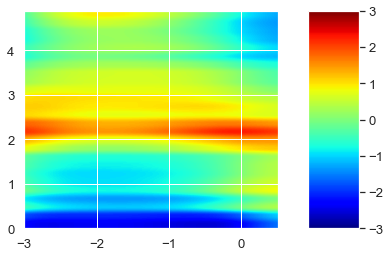

<ipython-input-263-9a9bce56ca23>:75: RuntimeWarning: The input signal is shorter (701) than "n_fft" (1024). Applying zero padding.
  decim=int(samplingrate / 100), return_itc=True)


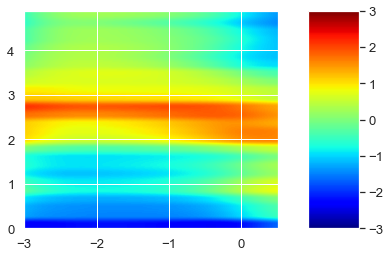

In [266]:
#for i in range(5):
idx3 = np.where(labels==2)
st_power1, itc1, freqs1, time = mne_stockell_power(epochs_data_train[idx3[0],0:1,:],200,window_lenght = [-3,0.5],freq_range = [0,5])

#st_power1, itc1, freqs1, time = mne_stockell_power(epochs_data_train[idx3[0][i]:idx3[0][i]+1,0:1,:],200,freq_range = [1,100])
plot_spectrograms(st_power1, itc1, freqs1,time)
    #print(st_power1.shape)
idx3 = np.where(labels==1)   
#for i in range(5):
st_power1, itc1, freqs1, time = mne_stockell_power(epochs_data_train[idx3[0],0:1,:],200,window_lenght = [-3,0.5],freq_range = [0,5])

#st_power1, itc1, freqs1, time = mne_stockell_power(epochs_data_train[idx3[0][i]:idx3[0][i]+1,0:1,:],200,freq_range = [1,100])
plot_spectrograms(st_power1, itc1, freqs1,time)

<ipython-input-151-13628f7fad5e>:75: RuntimeWarning: The input signal is shorter (801) than "n_fft" (1024). Applying zero padding.
  decim=int(samplingrate / 100), return_itc=True)


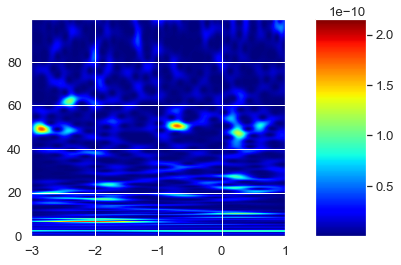

In [157]:
st_power1, itc1, freqs1, time = mne_stockell_power(epochs_data_train[idx3[0][1]:idx3[0][1]+1,0:1,:],200,window_lenght = [-3,1],freq_range = [0,100])
plot_spectrograms(st_power1, itc1, freqs1,time)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
#from mne.datasets import eegbci
from mne.decoding import CSP

print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after


# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier

print(labels)

idx1 = np.where(labels==1)
plt.figure()
plt.plot(np.mean(epochs_data_train[idx1[0],4,:],axis=0))
print(len(labels))

<ipython-input-32-ae2e09d6fa24>:75: RuntimeWarning: The input signal is shorter (401) than "n_fft" (512). Applying zero padding.
  decim=int(samplingrate / 100), return_itc=True)


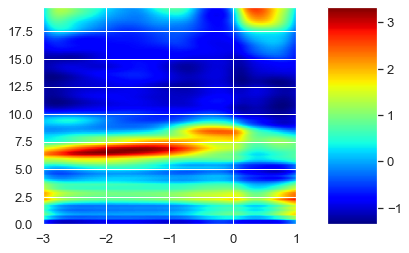

<ipython-input-32-ae2e09d6fa24>:75: RuntimeWarning: The input signal is shorter (401) than "n_fft" (512). Applying zero padding.
  decim=int(samplingrate / 100), return_itc=True)


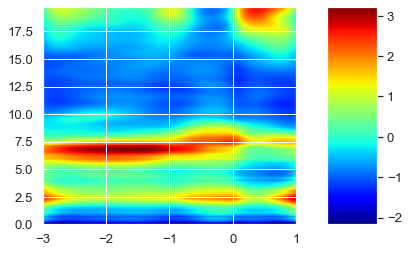

In [36]:
#idx3 = np.where(labels==1)
#st_power, itc, freqs, time = mne_stockell_power(epochs_data_train[idx3[0],0:1,:],200,freq_range = [20,100])
#plot_spectrograms(st_power, freqs,time)

st_power1, itc1, freqs1, time = mne_stockell_power(epochs_data_train[idx3[0][0],0:1,:],100,freq_range = [0,20])
plot_spectrograms(st_power1, itc1, freqs1,time)

#idx3 = np.where(labels==1)
#print(idx3[0])
#st_power, itc, freqs, time = mne_stockell_power(epochs_data_train[idx3[0],0:1,:],200,freq_range = [20,100])
#plot_spectrograms(st_power, freqs,time)

#st_power2, itc2, freqs2, time = mne_stockell_power(epochs_data_train[idx3[0],0:1,:],100,freq_range = [0,20])
#plot_spectrograms(st_power2,itc2, freqs2,time)


3873 events found
Event IDs: [1 2 3 4]
[[       0        0        1]
 [       1        1        2]
 [  301146        2        3]
 ...
 [16484813        1        2]
 [17204822        2        1]
 [17204830        1        2]]
647


</Users/qdo/opt/anaconda3/lib/python3.7/site-packages/decorator.py:decorator-gen-282>:12: RuntimeWarning: event -1 missing from event_id will be ignored
</Users/qdo/opt/anaconda3/lib/python3.7/site-packages/decorator.py:decorator-gen-282>:12: RuntimeWarning: event 1 missing from event_id will be ignored


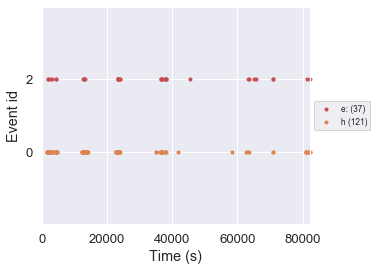

Not setting metadata
158 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 158 events and 801 original time points ...
0 bad epochs dropped
[0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 2 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 0 0 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0
 0 0 2 2 0 0 2 0 0 0 2 2 0 0 2 0 2 2 2 2 0 0 2 0 0 0 2 2 0 2 2 2 0 2 0 0 0
 0 0 2 0 0 0 0 2 0 0]


In [195]:
events = mne.find_events(ed, stim_channel=['STIM3'],shortest_event=1,min_duration=0.02,initial_event=True,consecutive=True)
event_simple = mne.pick_events(events, exclude=[1,2])
print(events)
savedEvent = []
#align to start of Trial!
for i in range(event_simple.shape[0]):
    if event_simple[i,2] == 3:
        if (i+1) < event_simple.shape[0]:
            if event_simple[i+1,2] == 4:
                savedEvent.append(event_simple[i,:])
            else:
                pass
        
print(len(savedEvent))
centerEvent = np.array(savedEvent)
centerEvent.shape
choiceLabel = np.array(dt.loc[:,"choice"])
rewardLabel = np.array(dt.loc[:,"reward"])
for i in range(len(choiceLabel)):
    if (choiceLabel[i] == "left") and (rewardLabel[i] == 0):
        choiceLabel[i] = 0 #left wrong
    elif (choiceLabel[i] == "left") and (rewardLabel[i] == 1):
        choiceLabel[i] = 1 #Left correct
    elif (choiceLabel[i] == "right") and (rewardLabel[i] == 0):
        choiceLabel[i] = 0 #right wrong
    elif (choiceLabel[i] == "right") and (rewardLabel[i] == 1):
        choiceLabel[i] = 1 #right correct
    elif choiceLabel[i] == "earlyleft":
        choiceLabel[i] = -1 #early left
    else:
        choiceLabel[i] = -1 #early right

#flashDiff = np.array(dt.loc[:,"dflash"])
for i in range(len(choiceLabel)):
    if (choiceLabel[i] == 0):
        if (flashDiff[i] > 5):
            choiceLabel[i] = 2
        else:
            choiceLabel[i] = 0
centerEvent[:,2] = choiceLabel
event_dict = {'h':0,
             'e:':2}
fig = mne.viz.plot_events(centerEvent, event_id=event_dict, sfreq=ed.info['sfreq'],
                          first_samp=ed.first_samp)

center_epochs = mne.Epochs(ed, centerEvent,event_id=event_dict, tmin=-1, tmax=3, preload=True,event_repeated='drop')

epochs_train = center_epochs.copy() #.crop(tmin=0.5, tmax=1)
labels = center_epochs.events[:, -1] 
print(labels)
epochs_data_train = epochs_train.get_data()

<ipython-input-191-360507a1cac0>:75: RuntimeWarning: The input signal is shorter (801) than "n_fft" (1024). Applying zero padding.
  decim=int(samplingrate / 100), return_itc=True)


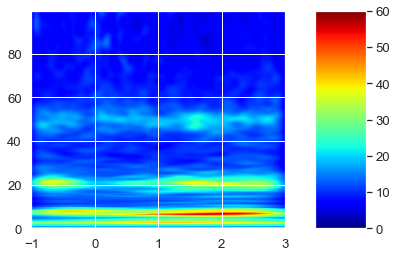

<ipython-input-191-360507a1cac0>:75: RuntimeWarning: The input signal is shorter (801) than "n_fft" (1024). Applying zero padding.
  decim=int(samplingrate / 100), return_itc=True)


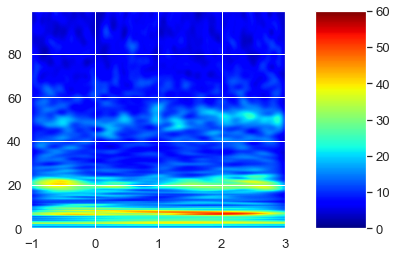

In [197]:
#for i in range(5):
idx3 = np.where(labels==0)
st_power1, itc1, freqs1, time = mne_stockell_power(epochs_data_train[idx3[0],0:1,:],200,window_lenght = [-1,3],freq_range = [0,100])

#st_power1, itc1, freqs1, time = mne_stockell_power(epochs_data_train[idx3[0][i]:idx3[0][i]+1,0:1,:],200,freq_range = [1,100])
plot_spectrograms(st_power1, itc1, freqs1,time)
    #print(st_power1.shape)
idx3 = np.where(labels==2)   
#for i in range(5):
st_power1, itc1, freqs1, time = mne_stockell_power(epochs_data_train[idx3[0],0:1,:],200,window_lenght = [-1,3],freq_range = [0,100])

#st_power1, itc1, freqs1, time = mne_stockell_power(epochs_data_train[idx3[0][i]:idx3[0][i]+1,0:1,:],200,freq_range = [1,100])
plot_spectrograms(st_power1, itc1, freqs1,time)

In [191]:
import matplotlib.pyplot as plt

import mne
from sklearn.preprocessing import StandardScaler
import numpy as np
def nextexp(value, base=2):
    """
    Given a value and an optional base, this function returns the exponent for
    the smallest powers of the specified base that satisfy:
    base**exponent >= |value|.

    Parameters
    ----------
    value : numeric
        The value that will be compared to the succesive powers of the base
        until the previous condition is met.
    base : numeric, optional
        The base of the power. Default value is 2.

    Returns
    -------
    int
        Exponent that meets the previous condition.

    """
    exponent = 0
    while base ** exponent < np.abs(value):
        exponent += 1
    return exponent

def mne_stockell_power(data, samplingrate, window_lenght = [-3,1], freq_range = [0,100]):
    """
        Computes a high temporal and frequency resolution spectrogram and intertrial coherence
        using the mne.time_frequency.tfr_array_stockwell function (https://mne.tools/stable/generated/mne.time_frequency.tfr_array_stockwell.html).
        It is set up to have a time resolution of 10ms and a frequency resolution depends on the window length.

        Parameters
        ----------
        data : ndarray
            The shape has to be (n_epochs, n_channels, n_times).
            For instance the shape for 2 events, 3 channels and 3000 points
            (3 seconds sampled at 1000) would be (1, 3, 3000)
        samplingrate : numeric
            Sampling frequency in Hz
        window_lenght: list, two numbers
            The seconds before the start of the trial, first number, and after
            the start of the trial, second number, that you want to plot.
        freq_rage: list, two numbers
        The frequency range that you want to calculate.


        Returns
        -------
        st_power: ndarray
            The multitaper power of the Stockwell transformed data.
            The last two dimensions are frequency and time. Shape (n_channels, n_freqs, n_time).
            It should have the same lenght of freqs, dimension 2, and time, dimension 3.
        itc: ndarray
        The intertrial coherence. Only returned if return_itc is True.
        Inter-trial coherence (ITC) is a measure that is computed from single trial EEG,
        which reflects the temporal and spectral synchronization within EEG,
        elucidating the extent to which underlying phase-locking occurs
        freqs: ndarray
        The points of frequencies that correspond to the frequencies calculated.
        Y axis spectrogram
        time: ndarray
        The points of time that correspond to the windowlenght,
        X axis spectrogram
        """


    st_power, itc, freqs = mne.time_frequency.tfr_array_stockwell(
        data, samplingrate, fmin=freq_range[0], fmax=freq_range[1],
        n_fft= np.power(2, nextexp(data.shape[-1], base=2)), width=1,
        decim=int(samplingrate / 100), return_itc=True)
    time = np.linspace(window_lenght[0], window_lenght[1], st_power.shape[-1])

    return st_power, itc, freqs, time

def plot_spectrograms(st_power, itc, freqs, time, freq_range = [0,100], cmap = 'jet', title = '' , channel = 0):
    """
    Simple function to plot

    st_power: ndarray
        The spectogram o itc data from the  mne_stockell_power funtion
    freqs: ndarray
        The points of frequencies that correspond to the frequencies calculated.
        Y axis spectrogram
    time: ndarray
        The points of time that correspond to the windowlenght,
        X axis spectrogram
    freq_rage: list, two numbers
        The frequency range that you want to calculate.
    cmap: string
        Colormap of the plot
    title: string
        Title of the plot
    channel: integer
        channel that you want to plot. Default 0, so it can also plot the mean of all channels (1 dimension).
    return:
    Plot
    """
#vmin=freq_range[0], vmax=freq_range[1]
    import matplotlib
    fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1] + [0.2],
                    'wspace': 0.2, 'hspace': 0.1})
    fig.suptitle(title, x=0.5, y=0.95)
    scaler = StandardScaler()
    data=(st_power[channel,:,:])*np.power(10,12) #uv^2/hz
    scaler.fit(data)
    toshow = scaler.transform(data)
    im = ax[0].imshow(
        (data), cmap=cmap, aspect='auto',vmin=0,vmax=60,
        interpolation='hanning',
        origin='lower', extent=(time[0],
                                time[-1], freqs[0],
                                freqs[-1]))
    fig.colorbar(im, cax=ax[1], orientation='vertical')
    plt.show()
    return None

<ipython-input-32-ae2e09d6fa24>:75: RuntimeWarning: The input signal is shorter (211) than "n_fft" (256). Applying zero padding.
  decim=int(samplingrate / 100), return_itc=True)


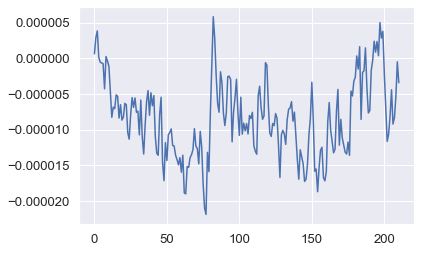

<Figure size 432x288 with 0 Axes>

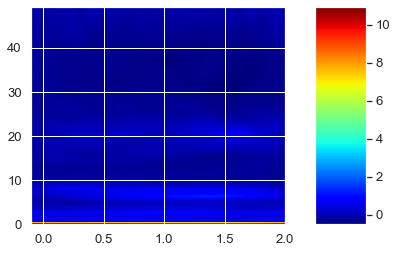

<ipython-input-32-ae2e09d6fa24>:75: RuntimeWarning: The input signal is shorter (211) than "n_fft" (256). Applying zero padding.
  decim=int(samplingrate / 100), return_itc=True)


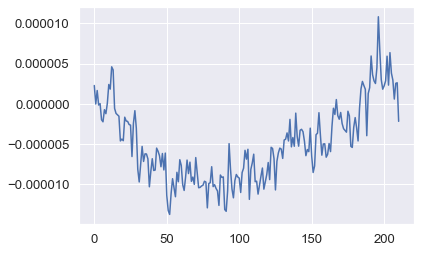

<Figure size 432x288 with 0 Axes>

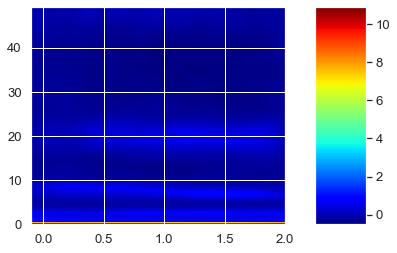

In [120]:
idx1 = np.where(labels==0)
plt.figure()
plt.plot(np.mean(epochs_data_train[idx1[0],0,:],axis=0))
#plt.plot(np.mean(epochs_data_train[idx1[0],1,:],axis=0))


plt.figure()
st_power1, itc1, freqs1, time = mne_stockell_power(epochs_data_train[idx1[0],0:1,:],100,window_lenght = [-1,2],freq_range = [0,50])
plot_spectrograms(st_power1, itc1, freqs1,time)

idx2 = np.where(labels==1)
plt.figure()
plt.plot(np.mean(epochs_data_train[idx2[0],0,:],axis=0))
#plt.plot(np.mean(epochs_data_train[idx2[0],1,:],axis=0))

plt.figure()
st_power1, itc1, freqs1, time = mne_stockell_power(epochs_data_train[idx2[0],0:1,:],100,window_lenght = [-1,2],freq_range = [0,50])
plot_spectrograms(st_power1, itc1, freqs1,time)

(321,)
(249,)


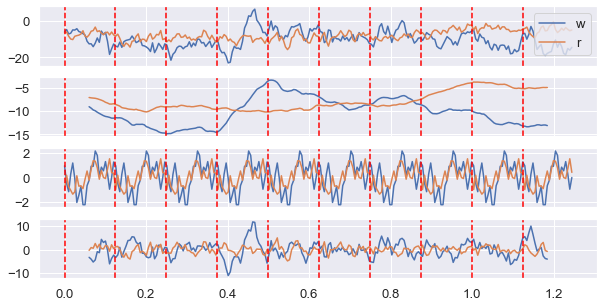

In [12]:
idx1 = np.where(labels==0)
idx2 = np.where(labels==1)
e = 1000000*epochs_data_train[idx1[0],0,:]
d = 1000000*epochs_data_train[idx2[0],0,:]
e = np.mean(e,axis=0)
d = np.mean(d,axis=0)

print(e.shape)
timesampled = e.shape[0]
timestart = 0.1+0.125

timestop = 1.375-0.125

e = e[int(timestart*timesampled):int(timestop*timesampled),]
d = d[int(timestart*timesampled):int(timestop*timesampled),]
print(e.shape)
from statsmodels.tsa.seasonal import seasonal_decompose
series5 = np.transpose(e)
result5 = seasonal_decompose(series5, model='additive',period=round(e.shape[0]/10))

series4 = np.transpose(d)
result4 = seasonal_decompose(series4, model='additive',period=round(e.shape[0]/10))

fig, ax = plt.subplots(4, 1, figsize=(10, 5),sharex=True)
ax[0].plot(np.arange(0,timestop,timestop/e.shape[0]),result5.observed,label='w')
ax[0].plot(np.arange(0,timestop,timestop/e.shape[0]),result4.observed,label='r')
ax[0].legend()
#ax[0].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[0].axvline(0.115*(i) + 0.01*(i), linestyle='--', color='red')

ax[1].plot(np.arange(0,timestop,timestop/e.shape[0]),result5.trend,label='w')
ax[1].plot(np.arange(0,timestop,timestop/e.shape[0]),result4.trend,label='r')
#ax[1].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[1].axvline( 0.115*(i) + 0.01*(i), linestyle='--', color='red')

ax[2].plot(np.arange(0,timestop,timestop/e.shape[0]),result5.seasonal,label='w')
ax[2].plot(np.arange(0,timestop,timestop/e.shape[0]),result4.seasonal,label='r')
#ax[2].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[2].axvline( 0.115*(i) + 0.01*(i), linestyle='--', color='red')


ax[3].plot(np.arange(0,timestop,timestop/e.shape[0]),result5.resid,label='w')
ax[3].plot(np.arange(0,timestop,timestop/e.shape[0]),result4.resid,label='r')
#ax[3].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[3].axvline(0.115*(i) + 0.01*(i), linestyle='--', color='red')
#ax[3].legend()

(249,)


Text(0.5, 0, 't(s)')

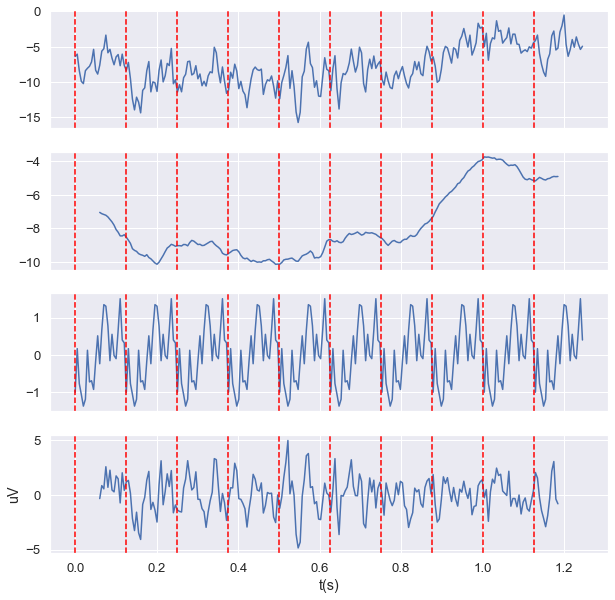

In [13]:
idx2 = np.where(labels==1)
d = 1000000*epochs_data_train[idx2[0],0,:]
d = np.mean(d,axis=0)

timesampled = d.shape[0]
timestart = 0.1+0.125

timestop = 1.375-0.125
d = d[int(timestart*timesampled):int(timestop*timesampled),]
print(e.shape)
from statsmodels.tsa.seasonal import seasonal_decompose

series4 = np.transpose(d)
result4 = seasonal_decompose(series4, model='additive',period=round(e.shape[0]/10))

fig, ax = plt.subplots(4, 1, figsize=(10, 10),sharex=True)
ax[0].plot(np.arange(0,timestop,timestop/d.shape[0]),result4.observed,label='r')
#ax[0].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[0].axvline(0.115*(i) + 0.01*(i), linestyle='--', color='red')

ax[1].plot(np.arange(0,timestop,timestop/d.shape[0]),result4.trend,label='r')
#ax[1].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[1].axvline( 0.115*(i) + 0.01*(i), linestyle='--', color='red')

ax[2].plot(np.arange(0,timestop,timestop/d.shape[0]),result4.seasonal,label='r')
#ax[2].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[2].axvline( 0.115*(i) + 0.01*(i), linestyle='--', color='red')


ax[3].plot(np.arange(0,timestop,timestop/d.shape[0]),result4.resid,label='r')
#ax[3].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[3].axvline(0.115*(i) + 0.01*(i), linestyle='--', color='red')
ax[3].set_ylabel("uV")
ax[3].set_xlabel("t(s)")
#ax[3].legend()

(249,)


Text(0.5, 0, 't(s)')

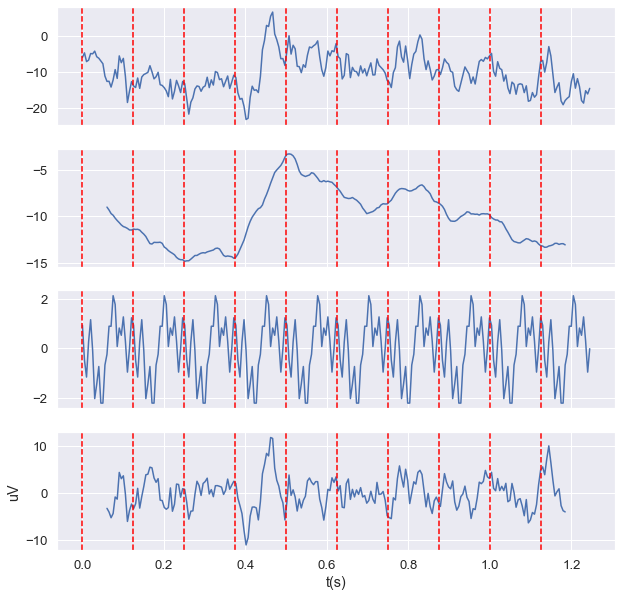

In [11]:
idx2 = np.where(labels==0)
d = 1000000*epochs_data_train[idx2[0],0,:]
d = np.mean(d,axis=0)

timesampled = d.shape[0]
timestart = 0.1+0.125

timestop = 1.375-0.125
d = d[int(timestart*timesampled):int(timestop*timesampled),]
print(e.shape)
from statsmodels.tsa.seasonal import seasonal_decompose

series4 = np.transpose(d)
result4 = seasonal_decompose(series4, model='additive',period=round(e.shape[0]/10))

fig, ax = plt.subplots(4, 1, figsize=(10, 10),sharex=True)
ax[0].plot(np.arange(0,timestop,timestop/d.shape[0]),result4.observed,label='r')
#ax[0].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[0].axvline(0.115*(i) + 0.01*(i), linestyle='--', color='red')

ax[1].plot(np.arange(0,timestop,timestop/d.shape[0]),result4.trend,label='r')
#ax[1].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[1].axvline( 0.115*(i) + 0.01*(i), linestyle='--', color='red')

ax[2].plot(np.arange(0,timestop,timestop/d.shape[0]),result4.seasonal,label='r')
#ax[2].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[2].axvline( 0.115*(i) + 0.01*(i), linestyle='--', color='red')


ax[3].plot(np.arange(0,timestop,timestop/d.shape[0]),result4.resid,label='r')
#ax[3].axvline(1.375, linestyle='--', color='k', label='Choice')
for i in range(10):
    ax[3].axvline(0.115*(i) + 0.01*(i), linestyle='--', color='red')
ax[3].set_ylabel("uV")
ax[3].set_xlabel("t(s)")

No handles with labels found to put in legend.


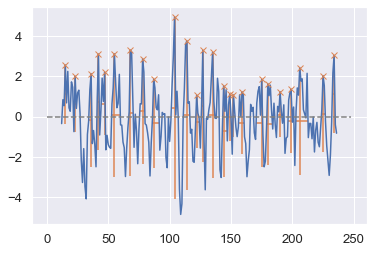

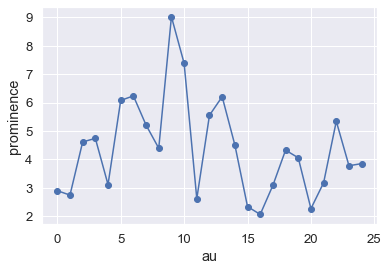

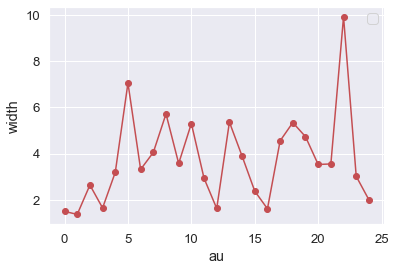

In [14]:
from scipy.signal import find_peaks
x = result4.resid
plt.figure()
#peaks, properties = find_peaks(x, height=2)
plt.plot(x)
#plt.plot(peaks, x[peaks], "x")
#plt.plot(np.zeros_like(x), "--", color="gray")
#plt.show()
#plt.figure()
peaks, properties = find_peaks(x, prominence=2, width=1)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")

plt.vlines(x=peaks, ymin=x[peaks] - properties["prominences"],
           ymax = x[peaks], color = "C1")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")


#peaks, properties = find_peaks(x, prominence=2, width=1)
p0 = properties["prominences"]
w0 = properties["widths"]
plt.figure()
plt.plot(p0,'bo-')
plt.xlabel("au")
plt.ylabel("prominence")
plt.figure()
plt.plot(w0,'ro-')
plt.xlabel("au")
plt.ylabel("width")
plt.legend()
plt.show()

(249,)


Text(0.5, 0, 'time bin')

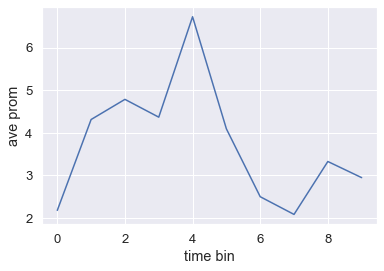

In [17]:
print(x.shape)
timesampled = x.shape[0]
am = []
for i in range(10):
    timestart = i*int(timesampled/10)
    timestop =  (i+1)*int(timesampled/10)
    #print(timestart)
    #print(timestop)
    peaks, properties = find_peaks(x[timestart:timestop], prominence=1, width=1)
    am.append(np.mean(properties["prominences"]))
plt.plot(am)
plt.ylabel("ave prom")
plt.xlabel("time bin")

Classification accuracy: 0.799398 / Chance level: 0.504537



Classification accuracy: 0.521584 / Chance level: 0.500000


Text(0.5, 1.0, 'choice decoding')

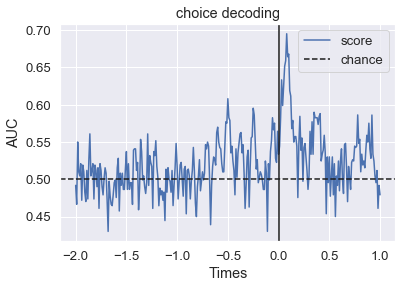

In [233]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import mne
from mne.datasets import sample
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

scores = []
epochs_data = choice_epochs.get_data()
epochs_data_train = epochs_train.get_data()
cv = ShuffleSplit(10, test_size=0.3, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
#lda = LinearDiscriminantAnalysis()
#csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

clf = make_pipeline(
    Vectorizer(),
    StandardScaler(),
    
#    CSP(n_components=4, reg=None, log=True, norm_trace=False),
#    Vectorizer(),
    SVC(gamma='auto')
    #LinearDiscriminantAnalysis()
    #LogisticRegression(solver='liblinear')
)

# Use scikit-learn Pipeline with cross_val_score function
#clf = Pipeline([('CSP', csp), ('LDA', lda)])
#clf = Pipeline([('LDA', lda)])

scores = cross_val_score(clf, epochs_data_train[:,0:1,:], labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

time_decod = SlidingEstimator(
    clf, n_jobs=1, scoring='roc_auc', verbose=True)
# here we use cv=3 just for speed
scores = cross_val_multiscore(time_decod, epochs_data_train[:,0:1,:], labels, cv=4, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          0.5))

# Plot
fig, ax = plt.subplots()
ax.plot(choice_epochs.times, scores, label='score')
ax.axhline(0.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')

ax.set_title('choice decoding')

In [166]:
from sklearn import metrics
lda = LinearDiscriminantAnalysis()

csp = CSP(n_components=3, reg=0.5, log=True, norm_trace=False)

AUC1 = []
full_epochs_data = choice_epochs.get_data()
full_epochs_data = full_epochs_data[:,0:1,:]
for i in range(19):
    #sel_epochs_train = choice_epochs.copy().crop(tmin=-2, tmax=-1.8+i*0.1)
    sel_epochs_train = choice_epochs.copy().crop(tmin=-2+i*0.1, tmax=-1.8+i*0.1)

    scores = []

    labels = choice_epochs.events[:, -1] 

    #epochs_train = choice_epochs.copy().crop(tmin=-2, tmax=-1.8)
    sel_epochs_data_train = sel_epochs_train.get_data()
    sel_epochs_data_train = sel_epochs_data_train[:,0:1,:]
    cv = ShuffleSplit(10, test_size=0.3, random_state=42)
    cv_split = cv.split(sel_epochs_data_train)

    sfreq = ed.info['sfreq']
    w_length = int(sfreq * 0.2)   # running classifier: window length
    w_step = int(sfreq * 0.1)  # running classifier: window step size
    w_start = np.arange(0, full_epochs_data.shape[2] - w_length, w_step)

    scores_windows = []

    for train_idx, test_idx in cv_split:
        y_train, y_test = labels[train_idx], labels[test_idx]

        X_train = csp.fit_transform(sel_epochs_data_train[train_idx], y_train)
        #X_test = csp.transform(epochs_data_train[test_idx])

        # fit classifier
        lda.fit(X_train, y_train)

        # running classifier: test classifier on sliding window
        score_this_window = []
        for n in w_start:
            X_test = csp.transform(full_epochs_data[test_idx][:, :, n:(n + w_length)])
            pred = lda.predict(X_test)
            fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
            score = metrics.auc(fpr, tpr)
            score_this_window.append(score)
        scores_windows.append(score_this_window)

    # Plot scores over time
    w_times = (w_start + w_length / 2.) / sfreq + choice_epochs.tmin
    AUC = np.mean(scores_windows, 0)
    AUC1.append(AUC)
    
AUC2 = []
for i in range(19):
    #sel_epochs_train = choice_epochs.copy().crop(tmin=-2, tmax=-1.8+i*0.1)
    sel_epochs_train = choice_epochs.copy().crop(tmin=-2, tmax=-1.8+i*0.1)

    scores = []

    labels = choice_epochs.events[:, -1] 

    #epochs_train = choice_epochs.copy().crop(tmin=-2, tmax=-1.8)
    sel_epochs_data_train = sel_epochs_train.get_data()
    sel_epochs_data_train = sel_epochs_data_train[:,0:1,:]
    cv = ShuffleSplit(10, test_size=0.3, random_state=42)
    cv_split = cv.split(sel_epochs_data_train)

    sfreq = ed.info['sfreq']
    w_length = int(sfreq * 0.2)   # running classifier: window length
    w_step = int(sfreq * 0.1)  # running classifier: window step size
    w_start = np.arange(0, full_epochs_data.shape[2] - w_length, w_step)

    scores_windows = []

    for train_idx, test_idx in cv_split:
        y_train, y_test = labels[train_idx], labels[test_idx]

        X_train = csp.fit_transform(sel_epochs_data_train[train_idx], y_train)
        #X_test = csp.transform(epochs_data_train[test_idx])

        # fit classifier
        lda.fit(X_train, y_train)

        # running classifier: test classifier on sliding window
        score_this_window = []
        for n in w_start:
            X_test = csp.transform(full_epochs_data[test_idx][:, :, n:(n + w_length)])
            pred = lda.predict(X_test)
            fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
            score = metrics.auc(fpr, tpr)
            score_this_window.append(score)
        scores_windows.append(score_this_window)

    # Plot scores over time
    w_times = (w_start + w_length / 2.) / sfreq + choice_epochs.tmin
    AUC = np.mean(scores_windows, 0)
    AUC2.append(AUC)
    



Computing rank from data with rank=None
    Using tolerance 8.2e-07 (2.2e-16 eps * 1 dim * 3.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-07 (2.2e-16 eps * 1 dim * 3.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 1 dim * 3.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 1 dim * 3.7e+09  max singular value)
    Estimated rank (ma

Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 1 dim * 3.6e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8e-07 (2.2e-16 eps * 1 dim * 3.6e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.4e-07 (2.2e-16 eps * 1 dim * 3.8e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-07 (

    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-07 (2.2e-16 eps * 1 dim * 3.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 7.9e-07 (2.2e-16 eps * 1 dim * 3.6e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.2e-07 (2.2e-16 eps * 1 dim * 3.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covarianc

    Using tolerance 8.2e-07 (2.2e-16 eps * 1 dim * 3.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-07 (2.2e-16 eps * 1 dim * 3.5e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 1 dim * 3.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e-07 (2.2e-16 eps * 1 dim * 3.5e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 da

Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e-07 (2.2e-16 eps * 1 dim * 3.4e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8e-07 (2.2e-16 eps * 1 dim * 3.6e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e-07 (2.2e-16 eps * 1 dim * 3.4e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8e-07 (2.2e-16 eps * 1 dim * 3.6e+09  ma

Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e-07 (2.2e-16 eps * 1 dim * 3.5e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 7.9e-07 (2.2e-16 eps * 1 dim * 3.5e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.4e-07 (2.2e-16 eps * 1 dim * 3.8e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 7.8e-07

    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8e-07 (2.2e-16 eps * 1 dim * 3.6e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 1 dim * 3.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 1 dim * 3.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Comput

    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.3e-07 (2.2e-16 eps * 1 dim * 3.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.4e-07 (2.2e-16 eps * 1 dim * 3.8e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.1e-07 (2.2e-16 eps * 1 dim * 3.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covarianc

    Using tolerance 8.3e-07 (2.2e-16 eps * 1 dim * 3.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.8e-07 (2.2e-16 eps * 1 dim * 4e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.3e-07 (2.2e-16 eps * 1 dim * 3.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.5e-07 (2.2e-16 eps * 1 dim * 3.8e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data

Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 7.9e-07 (2.2e-16 eps * 1 dim * 3.6e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.4e-07 (2.2e-16 eps * 1 dim * 3.8e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 7.2e-07 (2.2e-16 eps * 1 dim * 3.2e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 8.3e-07 (2.2e-16 eps * 1 dim * 3.8e+09

    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 7.7e-07 (2.2e-16 eps * 1 dim * 3.4e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 6.6e-07 (2.2e-16 eps * 1 dim * 3e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 7.6e-07 (2.2e-16 eps * 1 dim * 3.4e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Comput

    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e-07 (2.2e-16 eps * 1 dim * 2.6e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 6.7e-07 (2.2e-16 eps * 1 dim * 3e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e-07 (2.2e-16 eps * 1 dim * 2.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance 

    Using tolerance 6e-07 (2.2e-16 eps * 1 dim * 2.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 5.7e-07 (2.2e-16 eps * 1 dim * 2.6e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 5.7e-07 (2.2e-16 eps * 1 dim * 2.6e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 5.6e-07 (2.2e-16 eps * 1 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data

Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 5.6e-07 (2.2e-16 eps * 1 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 5.7e-07 (2.2e-16 eps * 1 dim * 2.6e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 5.6e-07 (2.2e-16 eps * 1 dim * 2.5e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 5.7e-07 (2.2e-16 eps * 1 dim * 2.5e+09

    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 9.8e-07 (2.2e-16 eps * 1 dim * 4.4e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 9.6e-07 (2.2e-16 eps * 1 dim * 4.3e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1e-06 (2.2e-16 eps * 1 dim * 4.5e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Comput

    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 1 dim * 5.1e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 1 dim * 5.1e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-06 (2.2e-16 eps * 1 dim * 5.1e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covarianc

    Using tolerance 1.4e-06 (2.2e-16 eps * 1 dim * 6.3e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 1 dim * 6.1e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 1 dim * 6.3e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-06 (2.2e-16 eps * 1 dim * 6.1e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 da

Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 1 dim * 6.6e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-06 (2.2e-16 eps * 1 dim * 6.5e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 1 dim * 6.8e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 1 dim * 6.7e+09

Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (2.2e-16 eps * 1 dim * 7.1e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 1 dim * 7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 1 dim * 7.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.6e-06 (

    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 1 dim * 7.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 1 dim * 7.9e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e-06 (2.2e-16 eps * 1 dim * 7.8e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covarianc

    Using tolerance 1.9e-06 (2.2e-16 eps * 1 dim * 8.3e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 1 dim * 8.5e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.8e-06 (2.2e-16 eps * 1 dim * 8.2e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-06 (2.2e-16 eps * 1 dim * 8.4e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 da

Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 1 dim * 9e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 1 dim * 9.2e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 1 dim * 9.3e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2e-06 (2.2e-16 eps * 1 dim * 8.9e+09  max singular value)
    Estimated rank (mag)

Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 1 dim * 9.4e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 1 dim * 9.4e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 1 dim * 9.4e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-06 (2.2e-16 eps * 1 dim * 9.7e+09

Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-06 (2.2e-16 eps * 1 dim * 1e+10  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (2.2e-16 eps * 1 dim * 9.7e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (2.2e-16 eps * 1 dim * 9.9e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (

    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-06 (2.2e-16 eps * 1 dim * 1e+10  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-06 (2.2e-16 eps * 1 dim * 1e+10  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-06 (2.2e-16 eps * 1 dim * 9.9e+09  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computin

    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-06 (2.2e-16 eps * 1 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-06 (2.2e-16 eps * 1 dim * 1e+10  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-06 (2.2e-16 eps * 1 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance 

    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-06 (2.2e-16 eps * 1 dim * 1e+10  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e-06 (2.2e-16 eps * 1 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e-06 (2.2e-16 eps * 1 dim * 1.1e+10  max singular value)
    Estimated rank (mag): 1
    MAG: rank 1 computed from 1 data channel with 0 projectors
Reducing data rank from 1 -> 1
Estimating covariance 

In [169]:
e1 = np.std(AUC1,axis=0, ddof=1) / np.sqrt(np.size(AUC1))
#print(e1)
#errors1 = [np.mean(AUC1, 0) - 0.95*e1, np.mean(AUC1, 0) + 0.95*e1]
e2 = np.std(AUC2,axis=0, ddof=1) / np.sqrt(np.size(AUC2))
#errors2 = [np.mean(AUC2, 0) - 0.95*e2, np.mean(AUC2, 0) + 0.95*e2]

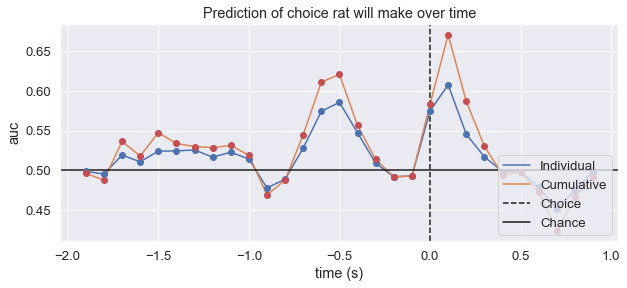

In [173]:
plt.figure(figsize=(10,4))


plt.plot(w_times, np.mean(AUC1, 0), label='Individual')
plt.plot(w_times, np.mean(AUC2, 0), label='Cumulative')
plt.errorbar(w_times, np.mean(AUC1, 0), yerr=e1, fmt='bo', ecolor = 'blue')
plt.errorbar(w_times, np.mean(AUC2, 0), yerr=e2, fmt='ro', ecolor = 'red')

plt.axvline(0, linestyle='--', color='k', label='Choice')
#plt.axvline(1.375, linestyle='--', color='r', label='GoCue')

plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('auc')
plt.title('Prediction of choice rat will make over time')
plt.legend(loc='lower right')
plt.show()

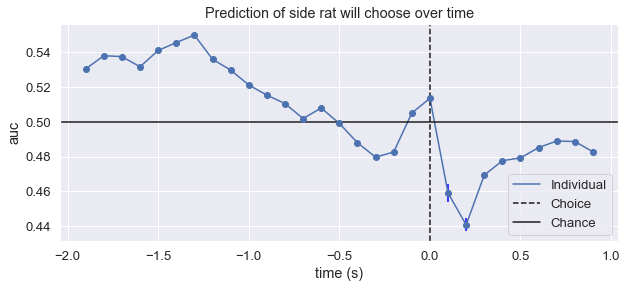

In [68]:
plt.figure(figsize=(10,4))


plt.plot(w_times, np.mean(AUC1, 0), label='Individual')
#plt.plot(w_times, np.mean(AUC2, 0), label='Cumulative')
plt.errorbar(w_times, np.mean(AUC1, 0), yerr=e1, fmt='bo', ecolor = 'blue')
#plt.errorbar(w_times, np.mean(AUC2, 0), yerr=e2, fmt='ro', ecolor = 'red')

plt.axvline(0, linestyle='--', color='k', label='Choice')
#plt.axvline(1.375, linestyle='--', color='r', label='GoCue')

plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('auc')
plt.title('Prediction of side rat will choose over time')
plt.legend(loc='lower right')
plt.show()

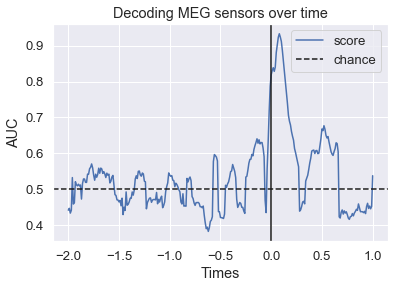

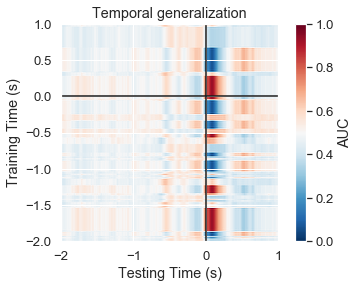

In [250]:
# define the Temporal generalization object
time_gen = GeneralizingEstimator(clf, n_jobs=4, scoring='roc_auc',
                                 verbose=True)

# again, cv=3 just for speed
scores = cross_val_multiscore(time_gen, epochs_data_train[:,1:2,:],labels, cv=3, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(choice_epochs.times, np.diag(scores), label='score')
ax.axhline(0.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Decoding MEG sensors over time')


fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=choice_epochs.times[[0, -1, 0, -1]], vmin=0., vmax=1.)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('AUC')

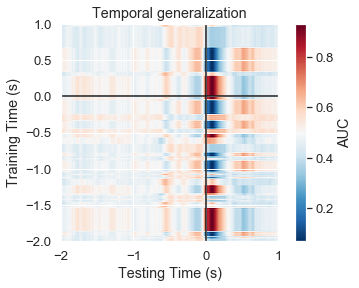

In [251]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
               extent=choice_epochs.times[[0, -1, 0, -1]])
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal generalization')
ax.axvline(0, color='k')
ax.axhline(0, color='k')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('AUC')

In [244]:
from sklearn import metrics
from mne.decoding import TimeFrequency
lda = LinearDiscriminantAnalysis()
from sklearn.svm import SVC

sv = SVC(gamma='auto',degree=5)
#csp = CSP(n_components=4, reg=0.5, log=True, norm_trace=False)
#frequencies = np.arange(8., 40., 1)
#tf = TimeFrequency(frequencies,ed.info['sfreq'],method='morlet', n_cycles=1, time_bandwidth=None, use_fft=True, decim=1, output='power', n_jobs=1, verbose=None)
#vv = Vectorizer()
clf = make_pipeline(
#    Vectorizer(),
    StandardScaler(),
    LogisticRegression(solver='liblinear')
)

AUC1 = []
full_epochs_data = choice_epochs.get_data()
full_epochs_data = full_epochs_data[:,0:1,:]
for i in range(27):
    #epochs_train = choice_epochs.copy().crop(tmin=-2, tmax=-1.8+i*0.1)
    sel_epochs_train = choice_epochs.copy().crop(tmin=0, tmax=0.2)

    scores = []

    labels = choice_epochs.events[:, -1] 

    #epochs_train = choice_epochs.copy().crop(tmin=-2, tmax=-1.8)
    sel_epochs_data_train = sel_epochs_train.get_data()
    sel_epochs_data_train = sel_epochs_data_train[:,0:1,:]
    cv = ShuffleSplit(10, test_size=0.3, random_state=42)
    cv_split = cv.split(sel_epochs_data_train)
  
    sfreq = ed.info['sfreq']
    w_length = int(sfreq * 0.2)   # running classifier: window length
    w_step = int(sfreq * 0.1)  # running classifier: window step size
    w_start = np.arange(0, full_epochs_data.shape[2] - w_length, w_step)

    scores_windows = []

    for train_idx, test_idx in cv_split:
        y_train, y_test = labels[train_idx], labels[test_idx]

        #X_train = vv.fit_transform(sel_epochs_data_train[train_idx], y_train)
        #X_test = csp.transform(epochs_data_train[test_idx])
        #print(X_train.shape)
        X_train = sel_epochs_data_train[train_idx]
        X_train = np.reshape(X_train, (X_train.shape[0],-1))
        #print(X_train.shape)

        # fit classifier
        clf.fit(X_train, y_train)

        # running classifier: test classifier on sliding window
        score_this_window = []
        for n in w_start:
            #X_test = vv.transform(full_epochs_data[test_idx][:, :, n:(n + w_length+1)])
            X_test = full_epochs_data[test_idx][:, :, n:(n + w_length+1)]

            #print(X_test.shape)

            X_test = np.reshape(X_test, (X_test.shape[0],-1))

            pred = clf.predict(X_test)
            fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
            score = metrics.auc(fpr, tpr)
            #print(score)
            score_this_window.append(score)
        scores_windows.append(score_this_window)

    # Plot scores over time
    w_times = (w_start + w_length / 2.) / sfreq + choice_epochs.tmin
    AUC = np.mean(scores_windows, 0)
    AUC1.append(AUC)

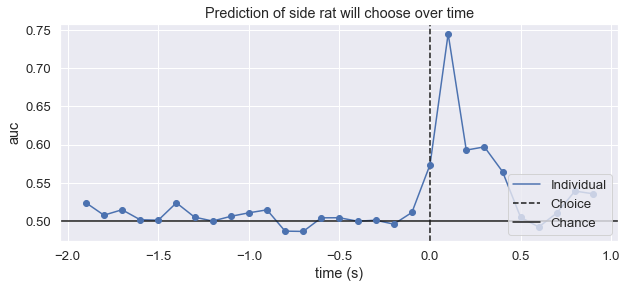

In [245]:
plt.figure(figsize=(10,4))
e1 = np.std(AUC1,axis=0, ddof=1) / np.sqrt(np.size(AUC1))


plt.plot(w_times, np.mean(AUC1, 0), label='Individual')

plt.axvline(0, linestyle='--', color='k', label='Choice')
#plt.axvline(1.375, linestyle='--', color='r', label='GoCue')
plt.errorbar(w_times, np.mean(AUC1, 0), yerr=e1, fmt='bo', ecolor = 'blue')

plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('auc')
plt.title('Prediction of side rat will choose over time')
plt.legend(loc='lower right')
plt.show()